## Homework 3: VQ-VAE

Ранее мы с вами познакомились с **вариационными автокодировщиками**, которые используют непрерывные скрытые переменные $\mathbf{z}_e$. Однако для многих типов данных дискретные представления могут быть более естественными.

**Vector Quantized Variational Autoencoder** (**VQ-VAE** ) — подход, позволяющий обучить автокодировщики с дискретным латентным пространством. Вместо того чтобы кодировать данные в непрерывное распределение ($\boldsymbol{\mu}, \boldsymbol{\sigma}^2$), `VQ-VAE` отображает их в один из векторов словаря (кодовой книги).

**Основная идея векторной квантизации состоит в следующем**:

1. Создается **кодовая книга** (**codebook**) — обучаемый словарь из $K$ векторов $\{\mathbf{e}_k\}_{k=1}^K$, где каждый вектор $\mathbf{e}_k \in \mathbb{R}^D$.
<center><img src="images/codebook.png" width=300></center>

2. **Кодировщик** $q_{\boldsymbol{\phi}}(c|\mathbf{x})$ преобразует входной объект $\mathbf{x}$ в непрерывное представление $\mathbf{z}_e \in \mathbb{R}^D$.

3. Для непрерывного вектора $\mathbf{z}_e$ находится **ближайший** к нему вектор $\mathbf{e}_{k^*}$ из кодовой книги:

$$k^* = \arg\min_k \|\mathbf{z}_e - \mathbf{e}_k\|$$

Результатом такого преобразования является **квантованный вектор** $\mathbf{z}_q = \mathbf{e}_{k^*}$.

<center><img src="images/clusters.png" width=250></center>

4. Квантованный вектор $\mathbf{z}_q$ передается в **декодер** $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}_q)$ для восстановления исходного объекта $\mathbf{\hat{x}}$.

В этой работе мы реализуем `VQ-VAE` и исследуем его свойства.

### Задание

Вам предстоит реализовать модель `VQ-VAE` и обучить модель на датасете `CIFAR10`.

За выполнение домашнего задания можно получить до **10 баллов**. Для части заданий мы написали для вас скелет. Заполните в них пропуски, выделенные с помощью `...`.

In [1]:
import os
from typing import List, Tuple, Dict

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

DATA_ROOT = './data'
DATA_LATENT_PATH = os.path.join(DATA_ROOT, 'latent')

### Задание 1: Dataset (0.5 балла)

Для обучения будем использовать датасет `CIFAR-10`.

**Ваша задача**:

- Загрузить `CIFAR-10`

- Создать преобразования `ToTensor` и `Normalize` в диапазон $[-1, 1]$

- Создать `Dataset`-ы и `DataLoader`-ы для обучающей и валидационной выборок

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# --- YOUR CODE HERE ---
# Преобразования для датасета
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

# Загружаем датасет с соответствующим преобразованием
train_dataset = CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform
)

val_dataset = CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=True,
    transform=transform
)

# Параметры загрузки
batch_size = 256
num_workers = 0
to_use_pin_memory = (device.type == 'cuda')

# Создаём генераторы батчей
# для трейна
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
    # так быстрее, но нельзя уйти в swap (часть данных система тащит на диск, если оперативки не хватает)
)
# для валидации
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

### Задание 2: Residual Blocks (0.5 балла)

В оригинальной статье `VQ-VAE` авторы использовали стек `ResNet` блоков как в кодировщике, так и в декодере, чтобы построить достаточно глубокие и мощные сверточные сети.

Структура блоков имеет следующий вид: `ReLU` $\rightarrow$ `Conv3x3` $\rightarrow$ `ReLU` $\rightarrow$ `Conv1x1`

Реализуйте классы `ResidualBlock` и `ResidualStack`, следуя архитектуре из статьи.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(inplace=True),
            # [b, in_channels, h, w] -> [b, num_residual_hiddens, h, w]
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            # [b, num_residual_hiddens, h, w] -> [b, num_hiddens, h, w]
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        # Implement the residual connection
        # x: [b, in_channels, h, w]
        # self.block(x): [b, num_hiddens, h, w]
        # x + self.block(x): [b, num_hiddens, h, w] (должно быть in_channels == num_hiddens)
        return x + self.block(x)


class ResidualBlockStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self._num_residual_layers = num_residual_layers
        # Create a list self.layers and add num_residual_layers instances of ResidualBlock to the list.
        # [b, in_channels, h, w] -> [b, num_hiddens, h, w] (должно быть in_channels == num_hiddens)
        self.layers = nn.ModuleList(
            [ResidualBlock(in_channels, num_hiddens, num_residual_hiddens)
             for _ in range(self._num_residual_layers)]
        )

    def forward(self, x):
        # Pass x through all layers and apply Relu after the entire stack
        # x: [b, in_channels, h, w] -> [b, num_hiddens, h, w]
        for i in range(self._num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)  # [b, num_hiddens, h, w]

### Задание 3: Encoder и Decoder (1 балл)

**Encoder** и **Decoder** в `VQ-VAE` — это сверточные нейросети, отвечающие за преобразование данных между исходным пространством изображений и пространством непрерывных латентных векторов

- **Encoder**:  сжимает входное изображение $\mathbf{x}$ в латентный вектор $\mathbf{z}_e$

- **Decoder**:  будет принимать на вход квантованный вектор $\mathbf{z}_q$, полученный из $\mathbf{z}_e$ после квантизации и восстанавливает из нее изображение $\hat{\mathbf{x}}$

Ваша задача — реализовать классы `Encoder` и `Decoder`.

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()

        # Define the layers based on the VQ-VAE paper description:
        # 1. Conv2d with stride 2 (kernel 4x4, padding 1) -> num_hiddens // 2 channels
        # [b, in_channels, h, w] -> [b, num_hiddens//2, h//2, w//2]
        self.conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens // 2,
            kernel_size=4,
            stride=2,
            padding=1,
        )

        # 2. Conv2d with stride 2 (kernel 4x4, padding 1) -> num_hiddens channels
        # [b, num_hiddens//2, h//2, w//2] -> [b, num_hiddens, h//4, w//4]
        self.conv_2 = nn.Conv2d(
            in_channels=num_hiddens // 2,
            out_channels=num_hiddens,
            kernel_size=4,
            stride=2,
            padding=1,
        )

        # 3. Conv2d with stride 1 (kernel 3x3, padding 1) -> num_hiddens channels
        # [b, num_hiddens, h//4, w//4] -> [b, num_hiddens, h//4, w//4]
        self.conv_3 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # 4. ResidualStack
        # [b, num_hiddens, h//4, w//4] -> [b, num_hiddens, h//4, w//4]
        self.residual_stack = ResidualBlockStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

    def forward(self, inputs):
        # Implement the forward pass:
        # Conv1 -> ReLU -> Conv2 -> ReLU -> Conv3 -> ResidualStack
        x = self.conv_1(inputs)  # [b, num_hiddens//2, h//2, w//2]
        x = F.relu(x)
        x = self.conv_2(x)  # [b, num_hiddens, h//4, w//4]
        x = F.relu(x)
        x = self.conv_3(x)  # [b, num_hiddens, h//4, w//4]

        return self.residual_stack(x)  # [b, num_hiddens, h//4, w//4]

In [6]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, out_channels):
        super().__init__()

        # Define the layers:
        # 1. Conv2d with stride 1 (kernel 3x3, padding 1) -> num_hiddens channels
        # [b, in_channels, h, w] -> [b, num_hiddens, h, w]
        self.conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # 2. ResidualStack
        # [b, num_hiddens, h, w] -> [b, num_hiddens, h, w]
        self.residual_stack = ResidualBlockStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

        # 3. ConvTranspose2d with stride 2 (kernel 4x4, padding 1) -> num_hiddens // 2 channels
        # [b, num_hiddens, h, w] -> [b, num_hiddens//2, h*2, w*2]
        self.conv_trans_1 = nn.ConvTranspose2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens // 2,
            kernel_size=4,
            stride=2,
            padding=1
        )
        # 4. ConvTranspose2d with stride 2 (kernel 4x4, padding 1) -> out_channels
        # [b, num_hiddens//2, h*2, w*2] -> [b, out_channels, h*4, w*4]
        self.conv_trans_2 = nn.ConvTranspose2d(
            in_channels=num_hiddens // 2,
            out_channels=out_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def forward(self, inputs):
        # Implement the forward pass:
        # Conv1 -> ResidualStack (applies ReLU) -> ConvTranspose1 -> ReLU -> ConvTranspose2
        # inputs: [b, in_channels, h, w]
        x = self.conv_1(inputs)  # [b, num_hiddens, h, w]
        x = self.residual_stack(x)  # [b, num_hiddens, h, w]
        x = self.conv_trans_1(x)  # [b, num_hiddens//2, h*2, w*2]
        x = F.relu(x)
        return self.conv_trans_2(x)  # [b, out_channels, h*4, w*4]

### Задание 4: VectorQuantizer (2 балла)

`VectorQuantizer` — это основной блок `VQ-VAE`, отвечающий за дискретизацию непрерывного латентного пространства.

Его основная задача для каждого вектора $\mathbf{z}_e$ найти индекс $k^*$ ближайшего вектора $\mathbf{e}_{k^*}$ из **обучаемой кодовой книги**:
$\{\mathbf{e}_k\}_{k=1}^K$.$$k^* = \arg\min_k \|\mathbf{z}_e - \mathbf{e}_k\|^2$$

И используя найденные индексы, извлечь соответствующие квантованные векторы $\mathbf{z}_q = \mathbf{e}_{k^*}$ из кодовой книги, которые и будут передаваться декодеру.

Однако проблема в том, что операция `argmin` недифференцируема, поскольку её производная почти везде равна нулю. Чтобы решить эту проблему, в `VQ-VAE` предложили использовать `Straight-Through Estimator`.

**Идея STE**:

На **прямом проходе** (**forward pass**) мы используем обычный результат операции квантования, т.е. выбираем ближайший вектор $\mathbf{z}_q = \mathbf{e}_{k^*}$.

На **обратном проходе** (**backward pass**) градиент $\nabla_{\mathbf{z}_q} \mathcal{L}$, который пришел от декодера к $\mathbf{z}_q$, используется в качестве аппроксимации для градиента по $\mathbf{z}_e$:

$$\nabla_{\mathbf{z}_e} \mathcal{L} \approx \nabla_{\mathbf{z}_q} \mathcal{L}$$

В итоге, градиент от декодера фактически пропускается через недифференцируемый блок квантования без изменений.

Хотя `STE` дает смещенную оценку градиента он всё же предоставляет кодировщику полезный обучающий сигнал. Градиент $\nabla_{\mathbf{z}_q} \mathcal{L}$ указывает, в каком направлении должен был бы измениться выбранный вектор $\mathbf{e}_{k^*}$, чтобы улучшить реконструкцию. Применяя этот же градиент к $\mathbf{z}_e$, мы подталкиваем выход кодировщика в такое направление, чтобы в следующий раз он с большей вероятностью был квантован в более "правильный" вектор из кодовой книги.


### VQ Loss

STE решает проблему проброса градиента к кодировщику, однако не предоставляет никакого обучающего сигнала для самой кодовой книги.

Поэтому, чтобы обучить кодовую книгу и стабилизировать кодировщик, в `VQ-VAE` вводят два дополнительных лосса:

$$L_{VQ} = \underbrace{\|\text{sg}[\mathbf{z}_e] - \mathbf{e}_{k^*}\|^2}_{\text{Codebook Loss}} + \underbrace{\beta \|\mathbf{z}_e - \text{sg}[\mathbf{e}_{k^*}]\|^2}_{\text{Commitment Loss}}$$

**Codebook Loss** отвечает за обучение кодовой книги, минимизируя $L_2$-расстояние между выходом кодировщика $\mathbf{z}_e$ и выбранным вектором $\mathbf{e}_{k^*}$. Это притягивает вектор $\mathbf{e}_{k^*}$ к $\mathbf{z}_e$. Оператор `stop-gradient` у $\mathbf{z}_e$ блокирует поток градиента к кодировщику. Это важно, так как гарантирует, что данное слагаемое лосса будет обновлять только веса кодовой книги.

**Commitment Loss** отвечает за обучение кодировщика, притягивая выход кодировщика $\mathbf{z}_e$ к выбранному вектору $\mathbf{e}_{k^*}$. Это заставляет кодировщик **фиксироваться** (**commit**) на выученных векторах словаря и предотвращает неконтролируемый рост его выходов. `Stop-gradient` у $\mathbf{e}_{k^*}$ блокирует поток градиента к кодовой книге, гарантируя, что это слагаемое будет отвечать только за кодировщик.

$\beta$ — это гиперпараметр, контролирующий силу фиксации.

### Perplexity

Часто для оценки того, насколько эффективно используется кодовая книга используется метрика **perplexity**. Она показывает эффективное количество векторов словаря, которые модель использует в среднем.

1. Для батча, состоящего из $N$ векторов $\mathbf{z}_e$ кодировщик выбирает $N$ индексов $k^*$.

2. Вычисляется среднее распределение $p$ использования кодов по этому батчу: $p = (p_1, ..., p_K)$, где $p_k$ — это средняя частота выбора $k$-го вектора из словаря.

3. **Perplexity** — это экспонента от энтропии $H(p)$ этого среднего распределения:$$PPL = e^{H(p)} = e^{-\sum_{k=1}^K p_k \log p_k}$$

**Hint**:

Низкая перплексия ($PPL << K$) указывает на **коллапс кодовой книги** (**codebook collapse**), высокая перплексия ($PPL \approx K$) указывает на хорошее, разнообразное использование словаря.

Ваша задача — заполнить пропуски в классе `VectorQuantizer`.

In [7]:
class VectorQuantizer(nn.Module):

    def __init__(self, num_embeddings: int, embedding_dim: int, beta: float):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1. / self.num_embeddings, 1. / self.num_embeddings)

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Connects the encoder output to the decoder input.
        Args:
            inputs (Tensor): Input tensor from encoder z_e [B, D, H, W].
        Returns:
            Tuple[Tensor, Tensor, Tensor]:
                vq_loss (scalar = Codebook Loss + beta * Commitment Loss),
                quantized_ste (tensor [B, D, H, W] with straight-through gradient),
                encoding_indices (tensor [N] (N=B*H*W) for perplexity calculation).
        """

        # Calculate L2 distance between inputs and embedding weights
        # [B, D, H, W] -> [B, H, W, D]
        z_e = inputs.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, D] -> [B*H*W, D]
        flat_z_e = z_e.view(-1, self.embedding_dim)
        # для каждых входа и эмбеддинга квадрат расстояния составляет
        # ||z_e||^2 + ||embedding||^2 - 2 * <z_e, embedding>
        # ||z_e||^2 [B*H*W, 1] - квадраты норм каждого входа
        # ||embedding||^2 [num_embeddings] - квадраты норм каждого эмбеддинга
        # тут происходит broadcasting ||z_e||^2 + ||embedding||^2
        # [B*H*W, 1] + [num_embeddings] -> [B*H*W, num_embeddings]
        # попарные скалярные произведения: матричное умножение z_es x embeddings.T
        # [B*H*W, D] x [D, num_embeddings] -> [B*H*W, num_embeddings]
        distances = (
                torch.sum(flat_z_e ** 2, dim=1, keepdim=True)
                + torch.sum(self.embedding.weight ** 2, dim=1)
                - 2 * torch.matmul(flat_z_e, self.embedding.weight.t())
        )

        # Find the indices of the closest embeddings
        encoding_indices = torch.argmin(distances, dim=1)  #[B*H*W]

        # Get the quantized latent vectors using embedding lookup
        quantized = self.embedding.weight[encoding_indices]  # [B*H*W, D]
        quantized = quantized.view(z_e.shape)  # [B, H, W, D]

        # Calculate the codebook loss: ||sg[z_e] - e_k*||^2, use detach() for sg
        codebook_loss = F.mse_loss(z_e.detach(), quantized)

        # Calculate the commitment loss: ||z_e - sg[e_k*]||^2
        commitment_loss = F.mse_loss(z_e, quantized.detach())

        # Combine the losses
        vq_loss = codebook_loss + self.beta * commitment_loss

        # Apply the Straight-Through Estimator
        # В прямом проходе:
        # .detach() не пропускает градиенты через выражение внутри себя.
        # (quantized - z_e).detach() — разница между квантизованным (дискретизированным) эмбеддинг-вектором
        # (lookup из codebook) и выходом энкодера (непрерывные), но без градиента, т.е. для backprop константа.
        # quantized_ste = quantized, потому что z_e + (quantized - z_e) = quantized
        quantized_ste = z_e + (quantized - z_e).detach()
        # [B, H, W, D] -> [B, D, H, W]
        quantized_ste = quantized_ste.permute(0, 3, 1, 2).contiguous()

        # В обратном проходе:
        # градиент по z_e пойдет так, как если бы выход был просто z_e.
        # То есть: grad(z_e + (quantized - z_e).detach()) == grad(z_e)
        # Градиент проходит через вход z_e так, будто квантизации и не было (т.е. "straight-through")

        return vq_loss, quantized_ste, encoding_indices

    def calculate_perplexity(self, encoding_indices: torch.Tensor) -> torch.Tensor:
        # Вариант 1. (https://github.com/AndrewBoessen/VQ-VAE/blob/main/vqvae.py)
        # encodings = torch.zeros(
        #     encoding_indices.shape[0], self.num_embeddings, device=self.num_embeddings.device
        # )  # [B*H*W, num_embeddings]
        # encodings.scatter_(1, encoding_indices.unsqueeze(1), 1)  # [B*H*W, num_embeddings]
        # probs = torch.mean(encodings, dim=0)  # [num_embeddings]
        # probs_nonzero = probs[probs > 0]  # слагаемые с нулями дадут ноль и так
        # perplexity = torch.exp(-torch.sum(probs_nonzero * torch.log(probs_nonzero + 1e-10)))
        # Вариант 2. Без создания матрицы
        # [B*H*W]
        encoding_indices = encoding_indices.view(-1)
        # [num_embeddings]
        counts = torch.bincount(encoding_indices, minlength=self.num_embeddings).float()
        probs = counts / counts.sum()  # [num_embeddings]
        probs_nonzero = probs[probs > 0]  # слагаемые с нулями дадут ноль и так
        perplexity = torch.exp(-torch.sum(probs_nonzero * torch.log(probs_nonzero + 1e-10)))

        return perplexity

### Задание 5: VQ-VAE (1 балл)

Теперь, когда у нас есть `Encoder`, `Decoder` и `VectorQuantizer`, мы можем собрать итоговую модель.

Реализуйте класс `VQVAE`, объединив все ранее созданные компоненты.

In [8]:
class VQVAE(nn.Module):
    def __init__(self, in_channels: int, embedding_dim: int, num_embeddings: int,
                 num_hiddens: int, num_residual_layers: int, num_residual_hiddens: int,
                 beta: float):
        super().__init__()

        # Initialize the encoder
        self._encoder = Encoder(
            in_channels=in_channels,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

        # Initialize the pre-quantization Conv2d with kernel_size=1, stride=1.
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim,
            kernel_size=1, stride=1
        )

        # Initialize the vector quantization layer
        self.vq_layer = VectorQuantizer(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            beta=beta
        )

        # Initialize the decoder
        self.decoder = Decoder(
            in_channels=embedding_dim,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            out_channels=in_channels
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through the VQ-VAE model.
        Args:
            x (Tensor): Input image tensor [B, C_in, H, W].
        Returns:
            Tuple[Tensor, Tensor, Tensor]:
                vq_loss (scalar = Codebook Loss + beta * Commitment Loss),
                x_hat_logits (tensor [B, C_in, H, W] - output logits from Decoder),
                encoding_indices (tensor [N = B*H'*W'] - flat indices for perplexity calculation).
        """
        # Pass `x` through the encoder to get `z_e`
        z_e = self._encoder(x)  # [B, num_hiddens, H', W']

        # Pass `z_e` through the pre-quantization conv
        z_e_pre_vq = self.pre_vq_conv(z_e)  # [B, embedding_dim, H', W']

        # Pass `z_e_pre_vq` through the quantization layer
        # z_q: [B, embedding_dim, H', W'], encoding_indices [N = B*H'*W']
        vq_loss, z_q, encoding_indices = self.vq_layer(z_e_pre_vq)

        # Pass the quantized vector `z_q` through the decoder
        x_hat_logits = self.decoder(z_q)  # [B, C_in, H, W]

        return vq_loss, x_hat_logits, encoding_indices

    @torch.no_grad()
    def decode_from_indices(self,
                            indices: torch.Tensor,
                            final_activation=nn.Tanh()) -> torch.Tensor:
        """
        Takes a grid of indices and decodes them into images.
        """
        self.eval()

        B, H, W = indices.shape

        # Get the quantized vectors `z_q`
        z_q = self.vq_layer.embedding.weight[indices.view(-1)]  # [B*H*W, D]
        z_q = z_q.view(B, H, W, -1)  # [B, H, W, D]
        z_q = z_q.permute(0, 3, 1, 2).contiguous()  # [B, D, H, W]

        # Pass `z_q` through the decoder
        out_logits = self.decoder(z_q)  # [B, C, H, W]

        # Apply the final activation
        out = final_activation(out_logits)

        return out

    @torch.no_grad()
    def sample(self,
               num_samples: int,
               latent_shape: Tuple[int, int],
               device: torch.device,
               final_activation=nn.Tanh()) -> torch.Tensor:
        """
        Generates images from random codes
        """
        self.eval()
        H, W = latent_shape
        # Generate random integer indices [B, H, W], значения от 0 до num_embeddings-1
        indices = torch.randint(
            self.vq_layer.num_embeddings,
            size=(num_samples, H, W),
            device=device
        )

        # Use `decode_from_indices` for decoding
        return self.decode_from_indices(indices, final_activation)

### Задание 6: Training and Validation Loop (1 балл)

Теперь, когда все компоненты модели готовы, мы можем собрать полный цикл обучения. Обучение `VQ-VAE` происходит путем минимизации суммарной функции потерь:
$$L_{total} = L_{rec} + L_{VQ},$$

- $L_{rec} = \|\mathbf{x} - \mathbf{\hat{x}}\|^2$ — лосс, вычисляемый между оригинальным $\mathbf{x}$ и восстановленным $\mathbf{\hat{x}}$ объектами
- $L_{VQ} = \|\mathbf{z}_e - \text{sg}[\mathbf{e}_{k^*}]\|^2 + \beta \|\text{sg}[\mathbf{z}_e] - \mathbf{e}_{k^*}\|^2$ — лосс, вычисляемый внутри `VectorQuantizer` для обучения кодовой книги и кодировщика.

Мы будем отслеживать все компоненты функции потерь (`total`, `reconstruction`, `vq`) и `Perplexity` на обучающей и валидационной выборках, чтобы контролировать процесс обучения.

Реализуйте функции `train_step_vqvae`, `validate_step_vqvae` и основной цикл `train_loop_vqvae`.

In [9]:
def train_step_vqvae(model, optimizer, train_loader, device, final_activation):
    model.train()

    epoch_losses = {'loss': 0.0, 'recon_loss': 0.0, 'vq_loss': 0.0, 'perplexity': 0.0}
    num_batches = len(train_loader)

    for batch_x, _ in tqdm(train_loader, desc="Train", leave=False):
        x = batch_x.to(device)
        optimizer.zero_grad()

        # Get model outputs
        vq_loss, x_hat_logits, encoding_indices = model(x)

        # Apply final activation
        x_hat = final_activation(x_hat_logits)

        # Calculate reconstruction loss, total loss, perplexity
        recon_loss = F.mse_loss(x_hat, x)
        loss = recon_loss + vq_loss
        perplexity = model.vq_layer.calculate_perplexity(encoding_indices)

        loss.backward()
        optimizer.step()

        # Get average losses over batches
        epoch_losses['loss'] += loss.item()
        epoch_losses['recon_loss'] += recon_loss.item()
        epoch_losses['vq_loss'] += vq_loss.item()
        epoch_losses['perplexity'] += perplexity.item()

    for loss_name in epoch_losses:
        epoch_losses[loss_name] /= num_batches

    return epoch_losses

In [10]:
@torch.no_grad()
def validate_step_vqvae(model, val_loader, device, final_activation):
    model.eval()
    epoch_losses = {'loss': 0.0, 'recon_loss': 0.0, 'vq_loss': 0.0, 'perplexity': 0.0}
    num_batches = len(val_loader)

    for batch_x, _ in tqdm(val_loader, desc="Val", leave=False):
        x = batch_x.to(device)

        # --- YOUR CODE HERE ---
        vq_loss, x_hat_logits, encoding_indices = model(x)
        x_hat = final_activation(x_hat_logits)
        recon_loss = F.mse_loss(x_hat, x)

        loss = recon_loss + vq_loss
        perplexity = model.vq_layer.calculate_perplexity(encoding_indices)

        epoch_losses['loss'] += loss.item()
        epoch_losses['recon_loss'] += recon_loss.item()
        epoch_losses['vq_loss'] += vq_loss.item()
        epoch_losses['perplexity'] += perplexity.item()

    for loss_name in epoch_losses:
        epoch_losses[loss_name] /= num_batches

    return epoch_losses


In [11]:
def visualize_reconstructions(model, data_loader, device, epoch, num_images=10, final_activation=F.tanh):
    model.eval()

    x_batch, _ = next(iter(data_loader))
    originals = x_batch[:num_images].to(device)

    _, x_hat_logits, _ = model(originals)
    reconstructions = final_activation(x_hat_logits)

    originals_cpu = originals.cpu()
    reconstructions_cpu = reconstructions.cpu()

    images_to_plot = torch.cat([originals_cpu, reconstructions_cpu], dim=0)
    grid = make_grid(images_to_plot * 0.5 + 0.5, nrow=num_images)

    plt.figure(figsize=(num_images * 1.5, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Reconstructions: Epoch {epoch} (Top: Original, Bottom: Reconstructed)")
    plt.axis('off')
    plt.show()

In [12]:
def plot_all_losses(train_stats, val_stats):
    clear_output()  # wait=True
    epochs = range(1, len(train_stats['loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    metrics_to_plot = [
        ('loss', 'Total Loss'),
        ('recon_loss', 'Reconstruction Loss'),
        ('vq_loss', 'VQ + Commitment Loss'),
        ('perplexity', 'Perplexity')
    ]

    for ax, (key, title) in zip(axes, metrics_to_plot):
        ax.plot(epochs, train_stats[key], label=f'Train {title}')
        ax.plot(epochs, val_stats[key], label=f'Validation {title}')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()

    fig.suptitle('Training VQ-VAE', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def save_checkpoint(model, optimizer, epoch, path_template):
    save_path = path_template.format(epoch=epoch)
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print(f"Checkpoint saved: {save_path}")

In [13]:
def train_loop_vqvae(model, optimizer, train_loader, val_loader, num_epochs, device,
                     checkpoint_path=None, final_activation=nn.Tanh()):
    model = model.to(device)
    train_history = {'loss': [], 'recon_loss': [], 'vq_loss': [], 'perplexity': []}
    val_history = {'loss': [], 'recon_loss': [], 'vq_loss': [], 'perplexity': []}

    for epoch in range(1, num_epochs + 1):
        train_epoch_stats = train_step_vqvae(model, optimizer, train_loader, device, final_activation)
        val_epoch_stats = validate_step_vqvae(model, val_loader, device, final_activation)

        for key in train_history:
            train_history[key].append(train_epoch_stats[key])
            val_history[key].append(val_epoch_stats[key])

        clear_output()  # wait=True
        plot_all_losses(train_history, val_history)

        visualize_reconstructions(model, val_loader, device, epoch)

        print(f"[Epoch {epoch}/{num_epochs}]")
        print(
            f"  Train: Loss={train_epoch_stats['loss']:.4f}, Recon={train_epoch_stats['recon_loss']:.4f}, VQ={train_epoch_stats['vq_loss']:.4f}, PPL={train_epoch_stats['perplexity']:.2f}")
        print(
            f"  Val:   Loss={val_epoch_stats['loss']:.4f}, Recon={val_epoch_stats['recon_loss']:.4f}, VQ={val_epoch_stats['vq_loss']:.4f}, PPL={val_epoch_stats['perplexity']:.2f}")

        save_checkpoint(model, optimizer, epoch, checkpoint_path)

In [14]:
loss_fn_recon = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 300
learning_rate = 5e-4

in_channels = 3
embedding_dim = 64
num_embeddings = 512
num_hiddens = 256
num_residual_layers = 2
num_residual_hiddens = 64
beta = 0.25

# Encoder: [B, 3, H, W] -> [B, 256, H//4, W//4]
# PreVQ: [B, 256, H//4, W//4] -> [B, 64, H//4, W//4]
# VQ: [B, 64, H//4, W//4] -> [B, 64, H//4, W//4]
# Decoder: [B, 64, H//4, W//4] -> [B, 3, H, W]
model = VQVAE(
    in_channels=in_channels,
    embedding_dim=embedding_dim,
    num_embeddings=num_embeddings,
    num_hiddens=num_hiddens,
    num_residual_layers=num_residual_layers,
    num_residual_hiddens=num_residual_hiddens,
    beta=beta
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
checkpoint_path = "checkpoints_vq/vqvae_epoch_{epoch}.pth"

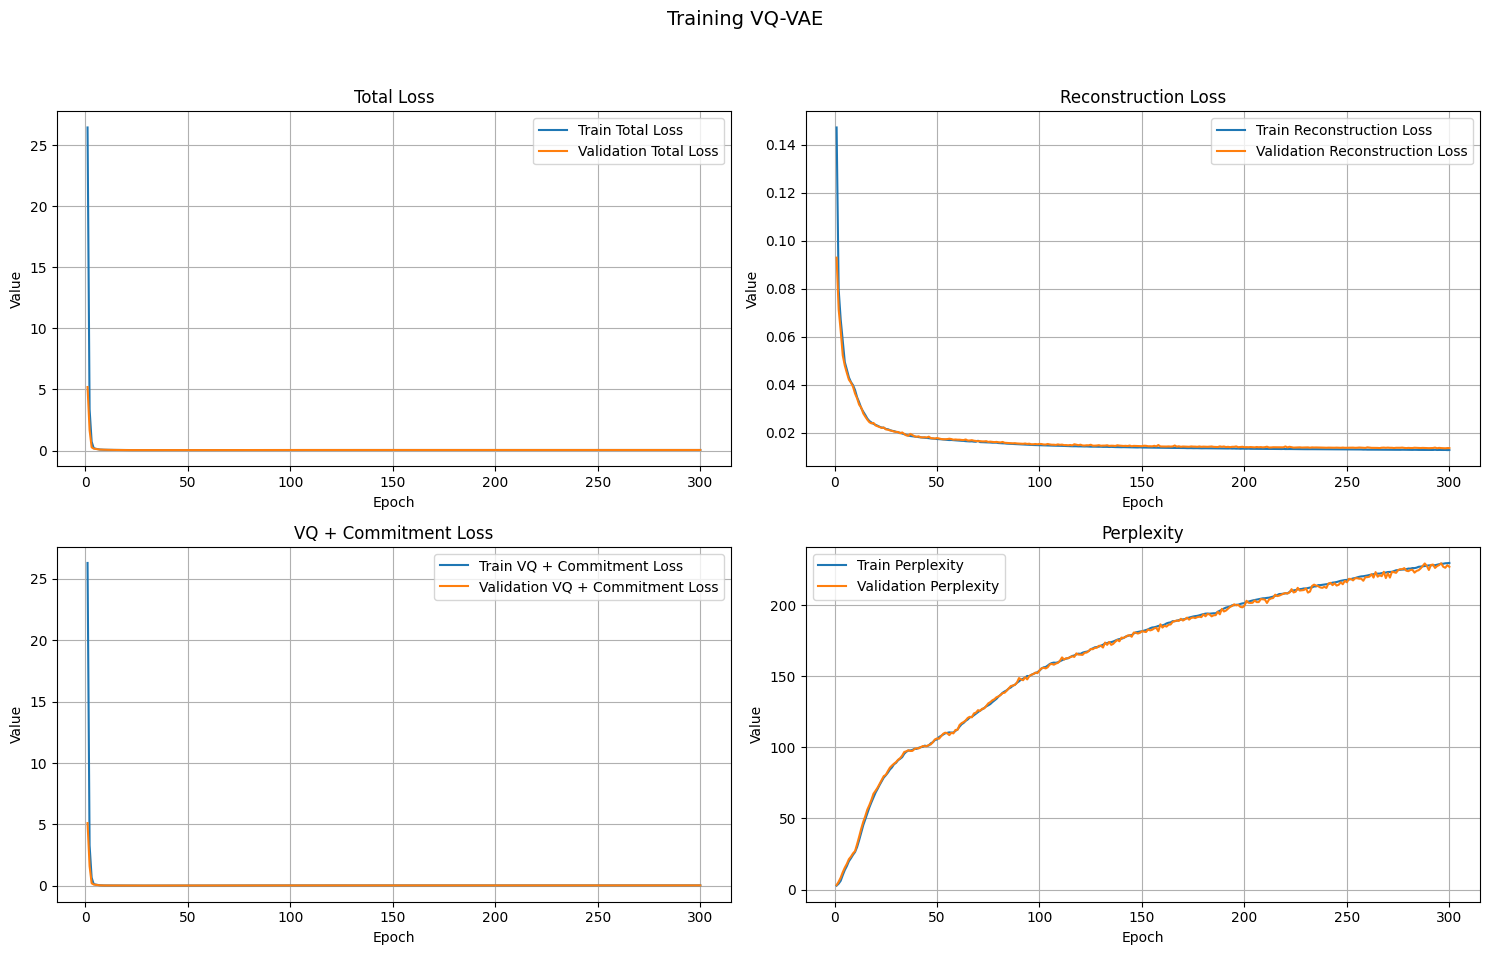

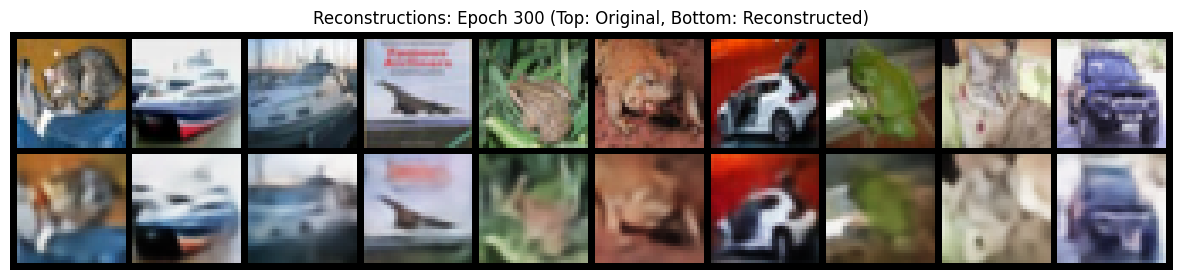

[Epoch 300/300]
  Train: Loss=0.0471, Recon=0.0129, VQ=0.0343, PPL=229.56
  Val:   Loss=0.0470, Recon=0.0137, VQ=0.0334, PPL=226.83
Checkpoint saved: checkpoints_vq/vqvae_epoch_300.pth


In [15]:
train_loop_vqvae(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
    checkpoint_path=checkpoint_path
)

### Задание 7: Sampling (0.5 балла)

После обучения `VQ-VAE` мы можем использовать его декодер для генерации новых изображений. Давайте попробуем это сделать, загрузив обученную модель.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqvae_checkpoint_path = 'checkpoints_vq/vqvae_epoch_300.pth'

model_vqvae = VQVAE(
    in_channels=3,
    embedding_dim=64,
    num_embeddings=512,
    num_hiddens=256,
    num_residual_layers=2,
    num_residual_hiddens=64,
    beta=0.25
).to(device)

checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)
model_vqvae.load_state_dict(checkpoint['model_state_dict'])
model_vqvae.eval()

VQVAE(
  (_encoder): Encoder(
    (conv_1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_stack): ResidualBlockStack(
      (layers): ModuleList(
        (0-1): 2 x ResidualBlock(
          (block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (pre_vq_conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (conv_1): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_stack): ResidualBlockStack(
      (layers): Mod

In [17]:
@torch.no_grad()
def visualize_generation(model, device, latent_shape=(8, 8), num_images=50, nrow=10):
    model.eval()

    samples = model.sample(num_images, latent_shape, device).cpu()

    grid = make_grid(samples * 0.5 + 0.5, nrow=nrow)

    plt.figure(figsize=(nrow * 1.5, (num_images // nrow) * 1.7))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Samples")
    plt.axis('off')
    plt.show()

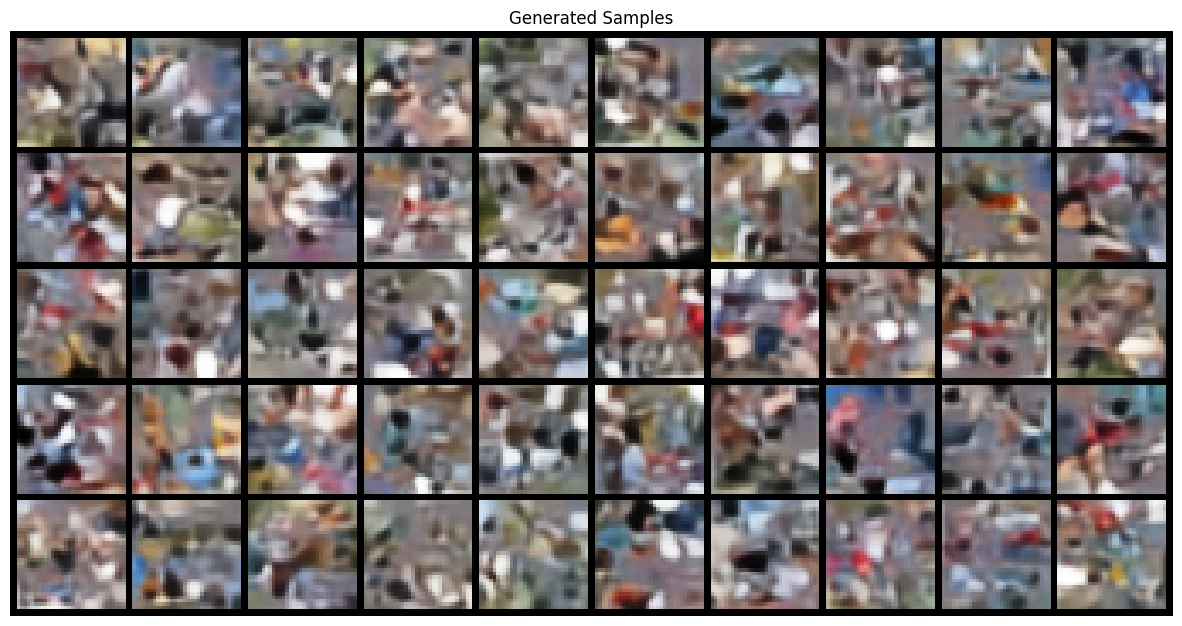

In [18]:
visualize_generation(model_vqvae, device)

**Вопрос**:

Почему сгенерированные изображения имеют такой вид?
Как это можно исправить?

**Ваш ответ**:
В реальных изображениях соседние пиксели в латентном пространстве связаны, а у нас случайные индексы, никак друг с другом не связанные, поэтому и создают "мозаику" без плавных переходов. VQ-VAE учится хорошо сжимать и восстанавливать, но не учится, какие комбинации кодов (индексов) имеют смысл. Другими словами, как из индекса получить пиксели модель неплохо научилась, а вот как составить набор индексов для генерации - не училась совсем. Поэтому необходимо обучить модель, которая могла бы создавать осознанные наборы индексов из латентного пространства, прежде, чем из них получать какое-то изображение.

### Learnable Prior

Итак, мы реализовали и обучили модель `VQ-VAE`. Она хорошо обучилась сжимать изображения в дискретное латентное пространство, а затем их восстанавливать. Однако, как вы могли заметить сама по себе `VQ-VAE` не является хорошей генеративной моделью.

Чтобы `VQ-VAE` могла генерировать качественные изображения, нам необходимо научиться моделировать априорное распределение $p(\mathbf{z})$ над этими дискретными скрытыми переменными. То есть, нам нужна модель, которая понимает, какие последовательности индексов являются осмысленными.

Для этой задачи отлично подходят авторегрессионные модели. Авторы оригинальной статьи предложили использовать для этого модель `Gated PixelCNN`.

### Задание 8: Latent Dataset (1 балл)

Поскольку PixelCNN будет работать не в пространстве пикселей, а в пространстве дискретных латентных переменных, нам необходимо предварительно создать этот датасет.

**Ваша задача**:

- Загрузить обученную модель VQ-VAE

- Реализовать функцию `get_code_indices`, которая прогоняет датасет изображений через кодировщик и `Vector Quantizer` и возвращает сетку индексов кодовой книги для каждого изображения

- Создать и сохранить датасеты индексов для обучающей и валидационной выборок `CIFAR-10`

- Реализовать класс `LatentCodeDataset` для загрузки полученных данных

- Создать `DataLoader`-ы для обучающей и валидационной выборок

In [18]:
# --- YOUR CODE HERE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqvae_checkpoint_path = 'checkpoints_vq/vqvae_epoch_300.pth'
vqvae_model = VQVAE(
    in_channels=3,
    embedding_dim=64,
    num_embeddings=512,
    num_hiddens=256,
    num_residual_layers=2,
    num_residual_hiddens=64,
    beta=0.25
).to(device)

checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)
vqvae_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
def get_code_indices(model, data_loader, device):
    all_indices = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Encoding"):
            images = images.to(device)

            # Pass images through the encoder
            z_e = model._encoder(images)  # [B, num_hiddens, H', W']

            # Pass z_e through the pre_vq_conv layer
            z_e_pre_vq = model.pre_vq_conv(z_e)  # [B, embedding_dim, H', W']

            # Get the encoding indices from the vq_layer.
            _, _, encoding_indices = model.vq_layer(z_e_pre_vq)  # [B*H'*W']
            latent_h, latent_w = z_e_pre_vq.shape[2], z_e_pre_vq.shape[3]
            indices_reshaped = encoding_indices.view(images.size(0), latent_h, latent_w)  # [B, H', W']

            # Append results
            all_indices.append(indices_reshaped.cpu())
            all_labels.append(labels.cpu())
    all_indices = torch.cat(all_indices, dim=0)  # [N, H', W']
    all_labels = torch.cat(all_labels, dim=0)  # [N]

    return all_indices, all_labels

In [27]:
os.makedirs(DATA_LATENT_PATH, exist_ok=True)
for dataset_name, data_loader in zip(['train', 'val'], [train_loader, val_loader]):
    all_indices, all_labels = get_code_indices(model=vqvae_model, data_loader=data_loader, device=device)
    save_path = os.path.join(DATA_LATENT_PATH, f"{dataset_name}_latent_codes.pth")
    torch.save({
        'indices': all_indices,
        'labels': all_labels,
        'latent_shape': (all_indices.size(1), all_indices.size(2)),
        'num_embeddings': model.vq_layer.num_embeddings
    }, save_path)

Encoding:   0%|          | 0/196 [00:00<?, ?it/s]

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [20]:
class LatentCodeDataset(Dataset):
    def __init__(self, data_path):
        data = torch.load(data_path)
        self.indices = data['indices']  # [N, H, W]
        self.labels = data['labels']  # [N]
        self.latent_shape = data['latent_shape']  # (H, W)
        self.num_embeddings = data['num_embeddings']

        print(f"Loaded latent dataset from {data_path}")
        print(f"Shape: {self.indices.shape}, Latent shape: {self.latent_shape}")
        print(f"Num embeddings: {self.num_embeddings}")

    def __len__(self):
        return self.indices.size(0)

    def __getitem__(self, idx):
        return self.indices[idx], self.labels[idx]

In [21]:
# Создание датасетов из сохраненных файлов
train_latent_dataset = LatentCodeDataset(os.path.join(DATA_LATENT_PATH, 'train_latent_codes.pth'))
val_latent_dataset = LatentCodeDataset(os.path.join(DATA_LATENT_PATH, 'val_latent_codes.pth'))

# Параметры загрузки
batch_size_latent = 512
num_workers = 0
to_use_pin_memory = (device.type == 'cuda')

# Создаём генераторы батчей
# для трейна
train_prior_loader = DataLoader(
    train_latent_dataset,
    batch_size=batch_size_latent,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
    # так быстрее, но нельзя уйти в swap (часть данных система тащит на диск, если оперативки не хватает)
)
# для валидации
val_prior_loader = DataLoader(
    val_latent_dataset,
    batch_size=batch_size_latent,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

print(f"Train prior loader: {len(train_prior_loader)} batches")
print(f"Val prior loader: {len(val_prior_loader)} batches")
print(f"Latent shape: {train_latent_dataset.latent_shape}")
print(f"Vocabulary size: {train_latent_dataset.num_embeddings}")

Loaded latent dataset from ./data\latent\train_latent_codes.pth
Shape: torch.Size([50000, 8, 8]), Latent shape: (8, 8)
Num embeddings: 512
Loaded latent dataset from ./data\latent\val_latent_codes.pth
Shape: torch.Size([10000, 8, 8]), Latent shape: (8, 8)
Num embeddings: 512
Train prior loader: 98 batches
Val prior loader: 20 batches
Latent shape: (8, 8)
Vocabulary size: 512


### Задание 9: Gated PixelCNN (1.5 балла)

Итак, чтобы `VQ-VAE` мог генерировать качественные изображения, нам необходимо смоделировать априорное распределение $p(\mathbf{z})$. Мы будем делать это с помощью авторегрессионной модели `Gated PixelCNN`. Вот её основные идеи:

- **Маскированные cвертки** (**Masked Convolutions**) видят только контекст (пиксели/коды выше и левее). `Маска A` применяется к первому слою, `маска B` — ко всем последующим.

- Для эффективного вычисления, в `Gated PixelCNN` используется два потока сверток:
    - **Вертикальный поток**: видит все строки над текущей
    - **Горизонтальный поток**: видит пиксели левее в текущей строке, а также обуславливается выходом вертикального потока

- Вместо стандартной **ReLU** используется **Gated Activations** $\mathbf{y} = \tanh(W_f * \mathbf{x}) \odot \sigma(W_g * \mathbf{x})$, что, как было показано авторами, значительно улучшает производительность.

<center><img src="images/GatedPixelCNN.png" width=350></center>

В этом задании вам нужно реализовать классы `GatedMaskedConv2d` и `GatedPixelCNN`.

In [22]:
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Split the input tensor `x` into two halves along the channel dimension (dim=1)
        # [B, 2*C, H, W] -> 2 [B, C, H, W]
        x_tanh, x_sigmoid = x.chunk(2, dim=1)

        # Apply tanh to the first half and sigmoid to the second half and return their element-wise product

        return torch.tanh(x_tanh) * torch.sigmoid(x_sigmoid)  # [B, C, H, W]

In [23]:
class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel_size, residual=True, n_classes=None):
        super().__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        self.mask_type = mask_type
        self.n_classes = n_classes
        self.residual = residual
        self.kernel_size = kernel_size

        # Conditional embedding
        if self.n_classes is not None:
            self.class_cond_embedding = nn.Embedding(n_classes, 2 * dim)

        # Vertical stack convolutions
        ks_v = (kernel_size // 2 + 1, kernel_size)
        pad_v = (0, kernel_size // 2)
        self.vert_stack = nn.Conv2d(dim, dim * 2, ks_v, 1, pad_v)
        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        # Horizontal stack convolutions
        ks_h = (1, kernel_size // 2 + 1)
        pad_h = (0, 0)
        self.horiz_stack = nn.Conv2d(dim, dim * 2, ks_h, 1, pad_h)
        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        """Applies Mask 'A' to the convolutional weights."""

        # Zero out the bottom row of the vertical stack's kernel
        with torch.no_grad():
            kernel_v = self.vert_stack.weight.data
            self.vert_stack.weight.data[:, :, kernel_v.size(2) // 2 + 1:, :] = 0

        # Zero out the right-most column of the horizontal stack's kernel
        with torch.no_grad():
            kernel_h = self.horiz_stack.weight.data
            kernel_h[:, :, :, kernel_h.size(3) // 2 + 1:] = 0

    def forward(self, x_v, x_h, y=None):
        # x_v: [B, C, H, W] - вход вертикального потока
        # x_h: [B, C, H, W] - вход горизонтального потока
        # y: [B] - метки классов (если есть)
        if self.mask_type == 'A':
            self.make_causal()

        y_cond = 0
        if y is not None and self.class_cond_embedding is not None:
            # [B] -> [B, 2*C] -> [B, 2*C, 1, 1]
            y_cond = self.class_cond_embedding(y).unsqueeze(-1).unsqueeze(-1)

        # 1. Vertical stack:
        #    Apply self.vert_stack to x_v
        #    Add y_cond
        #    Apply self.gate to get out_v
        # Вот тут способ настроить размеры https://discuss.pytorch.org/t/configure-a-convolutional-layer-so-the-padding-can-have-4-parameters-dimensions/111329/2
        x_v_pad = F.pad(x_v, (0, 0, self.kernel_size // 2, 0))  # [left, right, top, bot]
        h_vert = self.vert_stack(x_v_pad)  # [B, C, H, W] -> [B, 2*C, H, W]
        h_vert = h_vert + y_cond  # [B, 2*C, H, W] + [B, 2*C, 1, 1] -> [B, 2*C, H, W]
        out_v = self.gate(h_vert)  # [B, 2*C, H, W] -> [B, C, H, W]

        # 2. Horizontal stack:
        #    Apply self.vert_to_horiz to h_vert
        #    Apply self.horiz_stack to x_h
        #    Sum all components: vert_to_horiz + horiz_stack + y_cond
        #    Apply self.gate to get out
        h_vert_to_horiz = self.vert_to_horiz(h_vert)  # [B, 2*C, H, W] -> [B, 2*C, H, W]
        x_h_pad = F.pad(x_h, (self.kernel_size // 2, 0, 0, 0))  # [left, right, top, bot]
        h_horiz = self.horiz_stack(x_h_pad)  # [B, C, H, W] -> [B, 2*C, H, W]
        h_total = h_vert_to_horiz + h_horiz + y_cond  # [B, 2*C, H, W]
        out = self.gate(h_total)  # [B, 2*C, H, W] -> [B, C, H, W]

        # 3. Residual connection for the horizontal stream:
        if self.residual:
            out_h = self.horiz_resid(out) + x_h  # [B, C, H, W]
        else:
            out_h = out  # [B, C, H, W]

        return out_v, out_h  # оба тензора [B, C, H, W]

In [24]:
class GatedPixelCNN(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=128, n_layers=15, n_classes=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # Create the embedding layer
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        self.layers = nn.ModuleList()
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel_size = 7 if i == 0 else 3
            residual = False if i == 0 else True
            self.layers.append(
                GatedMaskedConv2d(mask_type, embedding_dim, kernel_size, residual, n_classes)
            )

        # Create the final output convolution layers
        #    nn.Sequential: Conv1x1 (D -> 512) -> ReLU -> Conv1x1 (512 -> K)
        self.output_conv = nn.Sequential(
            nn.Conv2d(embedding_dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, num_embeddings, 1)
        )

    def forward(self, x, y=None):
        # x: [B, H, W] - входные индексы (из словаря в сжатом изображении)
        # y: [B] - метки класса (при наличии)
        # Embed the input indices x
        x_emb = self.embedding(x)  # [B, H, W] -> [B, H, W, D]
        x_emb = x_emb.permute(0, 3, 1, 2).contiguous()  # [B, H, W, D] -> [B, D, H, W]

        # Initialize vertical and horizontal streams
        x_v, x_h = x_emb, x_emb  # оба [B, D, H, W]

        # Pass through all layers
        for layer in self.layers:
            x_v, x_h = layer(x_v, x_h, y)  # оба [B, D, H, W]

        # Apply the final output convolutions to `x_h` to get logits
        logits = self.output_conv(x_h)  # [B, D, H, W] -> [B, num_embeddings, H, W]

        return logits  # [B, K, H, W] где K = num_embeddings

    @torch.no_grad()
    def sample(self, y=None, shape=(8, 8), num_samples=10, device='gpu'):
        self.eval()
        H, W = shape
        latents = torch.zeros((num_samples, H, W), dtype=torch.int64).to(device)  # [B, H, W]

        if y is not None:
            y = y.to(device)  # [B]

        for i in range(H):
            for j in range(W):
                logits = self.forward(latents, y)  # [B, H, W] -> [B, K, H, W]
                logits_ij = logits[:, :, i, j]  # [B, K, H, W] -> [B, K]
                probs = F.softmax(logits_ij, dim=1)  # [B, K]
                sampled = torch.multinomial(probs, 1).squeeze(1)  # [B, K] -> [B]
                latents[:, i, j] = sampled  # [B, H, W] - обновляем один "пиксель"

        return latents  # [B, H, W] сетка с индексами

### Задание 10: Training and Validation Loop for PixelCNN (0.5 балла)

Реализуйте функции `train_prior`, `validate_prior` и основной цикл `train_loop_prior`.

In [25]:
def train_prior(model, optimizer, train_loader, criterion, device):
    model.train()
    total_loss = 0.0

    for codes, labels in tqdm(train_loader, desc="Prior Train", leave=False):
        codes, labels = codes.to(device), labels.to(device)  # codes [B, H, W], labels [B]

        # --- YOUR CODE HERE ---
        logits = model(codes, labels)  # [B, K, H, W], где K = num_embeddings размер словаря
        loss = criterion(logits, codes)  # cross_entropy [B, K, H, W] vs [B, H, W]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


@torch.no_grad()
def validate_prior(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    for codes, labels in tqdm(val_loader, desc="Prior Val", leave=False):
        codes, labels = codes.to(device), labels.to(device)  # codes [B, H, W], labels [B]

        # --- YOUR CODE HERE ---
        logits = model(codes, labels)  # [B, K, H, W]
        loss = criterion(logits, codes)  # cross_entropy [B, K, H, W] vs [B, H, W]
        total_loss += loss.item()

    return total_loss / len(val_loader)

In [30]:
def plot_prior_losses(train_losses, val_losses):
    clear_output()  # wait=True
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)


def visualize_prior_generation(prior_model, vqvae_model, device, shape=(8, 8), n_classes=10):
    prior_model.eval()
    vqvae_model.eval()

    labels_to_generate = torch.arange(n_classes).to(device)

    latent_codes = prior_model.sample(labels_to_generate, shape=shape,
                                      num_samples=n_classes, device=device)

    generated_images = vqvae_model.decode_from_indices(latent_codes).cpu()

    grid = make_grid(generated_images * 0.5 + 0.5, nrow=n_classes)
    plt.figure(figsize=(n_classes * 1.5, 3))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Generated Images with Prior')
    plt.axis('off')
    plt.show()

In [27]:
def train_loop_prior(prior_model, vqvae_model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    prior_model.to(device)
    vqvae_model.to(device)
    train_losses, val_losses = [], []
    latent_shape = train_loader.dataset.latent_shape  # (H, W) next(iter(train_loader))[0].shape[1:]

    for epoch in range(1, num_epochs + 1):
        avg_train_loss = train_prior(prior_model, optimizer, train_loader, criterion, device)
        avg_val_loss = validate_prior(prior_model, val_loader, criterion, device)
        # --- YOUR CODE HERE ---
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        clear_output()  # wait=True
        plot_prior_losses(train_losses, val_losses)
        visualize_prior_generation(prior_model, vqvae_model, device, shape=latent_shape)

        print(f"[Epoch {epoch}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

In [35]:
pixelcnn_embedding_dim = 128
pixelcnn_n_layers = 12

prior_num_epochs = 20
prior_learning_rate = 1e-4

prior_model = GatedPixelCNN(
    num_embeddings=num_embeddings,
    embedding_dim=pixelcnn_embedding_dim,
    n_layers=pixelcnn_n_layers,
    n_classes=10
).to(device)

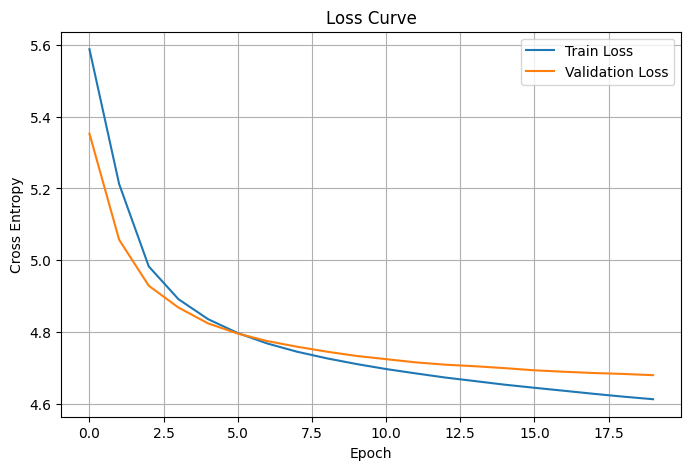

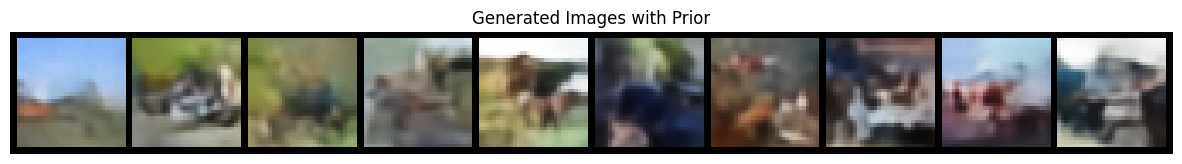

[Epoch 20/20] Train Loss: 4.6122 | Val Loss: 4.6793


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(prior_model.parameters(), lr=prior_learning_rate)

train_loop_prior(prior_model, vqvae_model, optimizer, train_prior_loader, val_prior_loader,
                 criterion, prior_num_epochs, device)


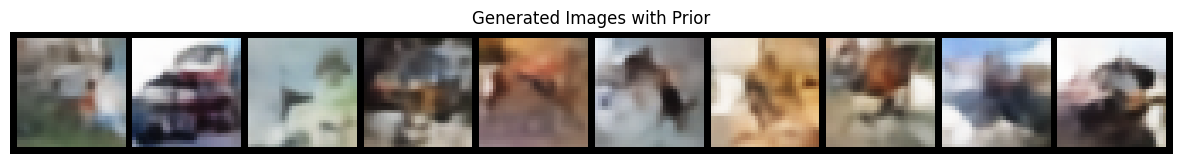

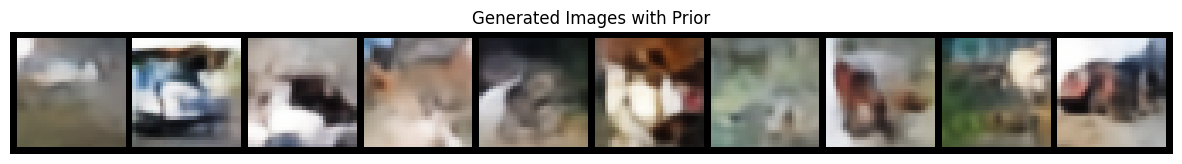

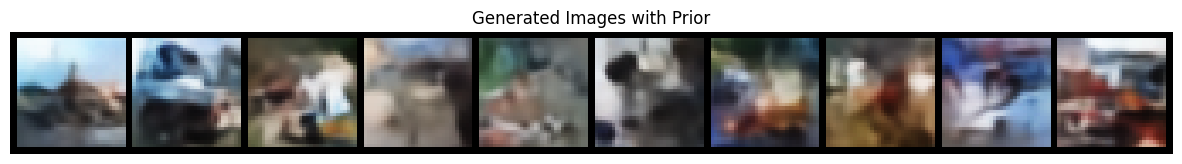

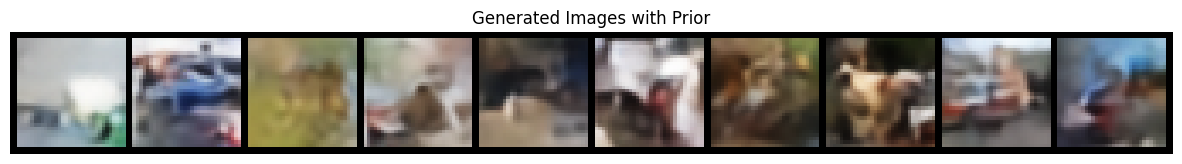

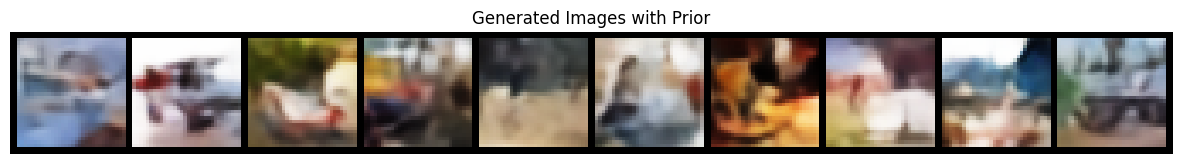

In [37]:
for _ in range(5):
    visualize_prior_generation(prior_model, vqvae_model, device, shape=(8, 8), n_classes=10)

### Задание 11: Выводы (0.5 балла)

Сгенерируйте 50 изображений с помощью функции `visualize_prior_generation`, посмотрите на них и сравните их с теми, что вы получили в **Задании 7**.

Ответьте на следующие вопросы:

1. Сравните качество изображений, сгенерированных с помощью **learnable prior**, и изображений, полученных путем наивного сэмплирования. В чем разница?

2. Почему обучение PixelCNN поверх дискретных кодов позволяет генерировать осмысленные изображения? Объясните роль **prior** $p(\mathbf{z})$.

**Ваш ответ**:
1. Разница в том, что при наивном сэмплировании получаем случайные мозаики без какого-то смысла, а при генерации с обученным **learnable prior** получаем какие-то объекты.

2. Почему обучение PixelCNN поверх дискретных кодов позволяет генерировать осмысленные изображения? Объясните роль **prior** $p(\mathbf{z})$.
Потому что PixelCNN мы научили правильным последовательностям "пикселей" (индексов из латентной кодовой книги). Наша модель PixelCNN генерирует не случайные пиксели, а такую последовательность, которая схожа с чем-то осмысленным. Поэтому на выходе и получаем более осмысленные картинки.

Примечание. С паддингами пришлось повозиться, чтоб размер картинки был правильный. Код без корректировок падал с ошибкой.